# Deep Averaging Network(DAN)
* import pretrain model from [TF-hub](hhttps://tfhub.dev/google/universal-sentence-encoder/3)
* Reference: [Blog](https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/)
* In this notebook, we try to encode one sentence into one feature vector according to the words it contains

In [0]:
%tensorflow_version 2.x  # use TF2.0

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # use TF2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__) # confirm version

2.0.0


In [0]:
import numpy as np
import pandas as pd
import re

## Load the dataset
Actually, we don't need to preprocess the sentences first, but it will also be good to try own sentences preprocessing

* When using self processed data:
  * ONLY need sentence and sentence length data
  * No need to tokenize first
  * *With or without stemming???* (you can change it in file ***Tokenize.ipynb***)

In [0]:
FILE = "./train.csv" #@param["./train_tokenize_nostem.csv","./train.csv"]

In [0]:
DATA = pd.read_csv(FILE)

## Select and Load model
you can try more but here we give two option

1. universal-sentence-encoder/v3 
2. universal-sentence-encoder-large/v4

In [0]:
 model_URL = "https://tfhub.dev/google/universal-sentence-encoder-large/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/3", "https://tfhub.dev/google/universal-sentence-encoder-large/4"]

In [0]:
embed = hub.load(model_URL)

In [0]:
#test
print(DATA.loc[0,'Sentences'])
print(type(DATA.loc[0,'Sentences']))
print(embed([DATA.loc[0,'Sentences']])) # input must be a vector (must enclose by [])
#get the output using 
# embed([DATA.loc[0,'Sentences']])['outputs']

Rapid popularity of Internet of Things (IoT) and cloud computing permits neuroscientists to collect multilevel and multichannel brain data to better understand brain functions, diagnose diseases, and devise treatments.
<class 'str'>
{'outputs': <tf.Tensor: id=85331, shape=(1, 512), dtype=float32, numpy=
array([[ 1.82004110e-03,  2.72639114e-02, -3.66953686e-02,
        -2.64367089e-02,  4.33560982e-02, -8.22366960e-03,
         9.74366162e-03,  1.17335552e-02, -3.78652923e-02,
         8.53110570e-03, -5.70714995e-02, -3.38755660e-02,
        -3.33005972e-02,  3.62619683e-02, -2.52643880e-03,
        -1.98837020e-03, -8.85189883e-03,  6.33319616e-02,
         3.83328833e-02,  3.06463540e-02,  1.57843027e-02,
         4.85022515e-02, -1.77949015e-02, -1.60468742e-02,
        -1.42130489e-02,  4.78058727e-03,  3.20206955e-02,
         4.70108241e-02,  3.34846638e-02,  8.97763576e-03,
         5.43726701e-03, -2.09626481e-02,  5.70670478e-02,
        -1.24927172e-02,  2.44400348e-03, -2.3

## Prepare tain/val and label
* here I only train and predict on the sentences that **length>1** (depend on you)
* If using the non-preprocessing version, then don't choose among **LENGTH** which is calculate *AFTER* preprocessing


In [0]:
if FILE == "./train_tokenize_nostem.csv":
  TRAIN = DATA.loc[DATA['LENGTH']>1, 'Sentences']
  LABEL = DATA.loc[DATA['LENGTH']>1,'BACKGROUND':'OTHERS'] #:'OTHERS'
else:
  TRAIN = DATA.loc[:, 'Sentences']
  LABEL = DATA.loc[:,'BACKGROUND':'OTHERS'] 

print(TRAIN.shape)
print(LABEL.shape)

(46867,)
(46867, 6)


In [0]:
#split to train and val
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(TRAIN, LABEL,  test_size=0.25)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', Y_train.shape)
print('X_test.shape: ', X_val.shape)
print('y_test.shape: ', Y_val.shape)

X_train.shape:  (35150,)
y_train.shape:  (35150, 6)
X_test.shape:  (11717,)
y_test.shape:  (11717, 6)


## Construct the model with keras

### Prepare TF dataset (based on above X_train/val Y_train/val)
* Shuffle the dataset 
* set batch size
* Prefetch the dataset to speed up data preparation
* reference : [tf.Dataset](https://www.tensorflow.org/guide/data_performance#optimize_performance)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, Y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, Y_val.values))
#investigate the dataset
for feat, targ in train_dataset.take(3):
  print ('Features: {}, Target: {}'.format(feat, targ))

print ('--------------------------------------------------')
BATCH_SIZE = 64

# shuffle, set batch and set prefetch
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(10000).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# now it will take 1 batch out and the order is messed (only show 5 below)
for feat, targ in train_dataset.take(1):
  print ('Features: {}, Target: {}'.format(feat[0:5], targ[0:5]))

Features: b'Estimation of social influence in networks can be substantially biased in observational studies due to homophily and network correlation in exposure to exogenous events.', Target: [1 0 0 0 0 0]
Features: b'We report initial results on MNIST and on the Weizmann video event recognition benchmarks.', Target: [0 0 0 1 0 0]
Features: b'In this paper we present an online wide-area oscillation damping control (WAC) design for uncertain models of power systems using ideas from reinforcement learning.', Target: [0 1 0 0 0 0]
--------------------------------------------------
Features: [b'Plans for future development include support for experimental data from laminar flame, jet stirred reactor, and speciation measurements.'
 b'We provide a limitation for the first question that an ITS quantum FHE necessarily incurs exponential overhead.'
 b"Orthogonal multiple access (OMA) technologies in today's mobile systems fall inefficient in the presence of such massive connectivity and traffic

### define embed layer from above loaded pre-trained function

In [0]:
def UniversalEmbedding(x):
  return embed(tf.squeeze(tf.cast(x, tf.string)))['outputs']

In [0]:
# example of the output of this layer
for feat, targ in train_dataset.take(1):
  print(UniversalEmbedding(feat))

tf.Tensor(
[[-0.02008026 -0.00319684 -0.07242701 ...  0.04616326 -0.00133737
  -0.02405854]
 [ 0.03738686 -0.02246807 -0.03222997 ...  0.00942885 -0.05407602
  -0.07303442]
 [ 0.02276364  0.0392     -0.03963111 ...  0.02302552  0.04935707
  -0.03361338]
 ...
 [-0.02917023 -0.02327572 -0.03011437 ... -0.06966508  0.039978
  -0.0151872 ]
 [-0.03769828  0.00010671 -0.03004189 ...  0.01629269 -0.01127007
  -0.05320746]
 [-0.04391906  0.03447077 -0.06349262 ... -0.03988873 -0.00364659
  -0.08000599]], shape=(64, 512), dtype=float32)


### define model
* Also define a F1_score metric

In [0]:
def F1_score(y_true, y_pred):
  DTYPE = tf.float32
  THRESHOLD = 0.5

  y_pred = tf.cast(y_pred > THRESHOLD, DTYPE) 

  true_positives = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(y_pred,1.0), tf.math.equal(y_true,1.0)), axis=0)
  false_positives = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(y_pred,1.0), tf.math.equal(y_true,0.0)), axis=0)
  false_negatives = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(y_pred,0.0), tf.math.equal(y_true,1.0)), axis=0)

  TP = tf.math.reduce_sum(tf.cast(true_positives, DTYPE), axis=0)
  FP = tf.math.reduce_sum(tf.cast(false_positives, DTYPE), axis=0)
  FN = tf.math.reduce_sum(tf.cast(false_negatives, DTYPE), axis=0)

  precision = tf.math.divide_no_nan(TP, TP+FP)
  recall = tf.math.divide_no_nan(TP, TP+FN)

  F1 = tf.math.divide_no_nan(2 * (precision * recall) , (precision + recall))
  return F1

In [0]:
# using Dropout and kernel_regularizer to prevent overfitting
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(UniversalEmbedding, output_shape=(512,)),
    tf.keras.layers.Dropout(0.5),                        
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
#compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[F1_score])

# build the model to get the weight
model.build((BATCH_SIZE,None))
model.summary()
# store the weight for later usage
weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  131328    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16448     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  3

### Training
* we can use [Tensorboard](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to see the train progress

In [0]:
# initialize Tensorboard
import os, datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_F1_score',mode='max', patience=5)

In [0]:
history = model.fit(train_dataset, epochs=40, verbose=1,
                    validation_data=val_dataset, 
                    callbacks = [earlystop],
                    # callbacks=[earlystop,tensorboard_callback],  #-> if you want to have a visualization from Tensorboard
                    validation_steps=30)

In [0]:
# open the tensorboard to see the training progress
%load_ext tensorboard
%tensorboard --logdir logs

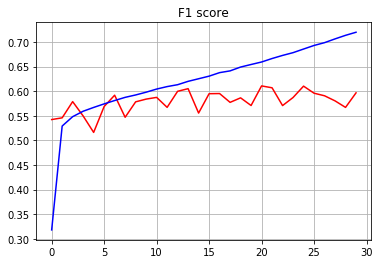

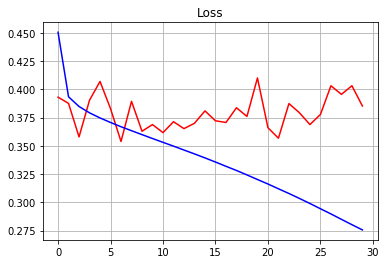

In [0]:
# Or simply using matplot
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(history.history['val_F1_score'], 'r')
plt.plot(history.history['F1_score'], 'b')
plt.title('F1 score')
plt.grid()
plt.figure(2)
plt.plot(history.history['val_loss'], 'r')
plt.plot(history.history['loss'], 'b')
plt.title('Loss')
plt.grid()
plt.show()

### Result
---
#### if seperate each label
* **BAKGROUND**: Epoch 13 loss: 0.2630 - F1_score: 0.7857 - accuracy: 0.8990 - val_loss: 0.3612 - val_F1_score: 0.7023 - val_accuracy: 0.8542
* **OBJECTIVES**: Epoch 14 loss: 0.3016 - F1_score: 0.5519 - accuracy: 0.8776 - val_loss: 0.4195 - val_F1_score: 0.4398 - val_accuracy: 0.8438
* **METHODS**: Epoch 14 loss: 0.3223 - F1_score: 0.7197 - accuracy: 0.8629 - val_loss: 0.4929 - val_F1_score: 0.4974 - val_accuracy: 0.7979
* **RESULTS**: Epoch 14 loss: 0.2942 - F1_score: 0.6955 - accuracy: 0.8792 - val_loss: 0.4621 - val_F1_score: 0.5721 - val_accuracy: 0.8083  
* **CONCLUSIONS**:  Epoch 13 loss: 0.1982 - F1_score: 0.3779 - accuracy: 0.9227 - val_loss: 0.2962 - val_F1_score: 0.1500 - val_accuracy: 0.9062
* **OTHERS**: Epoch 13 loss: 0.0361 - F1_score: 0.1100 - accuracy: 0.9881 - val_loss: 0.0748 - val_F1_score: 0.0667 - val_accuracy: 0.9854

#### Predict together without OTHERS
* Epoch 11 loss: 0.4363 - F1_score: 0.4815 - val_loss: 0.3970 - val_F1_score: 0.5506

In [0]:
## Evaluate
result = model.predict(X_val.values)

print(result.shape)
print(result[-5:-1])

(11717, 5)
[[0.08028388 0.0453527  0.16501787 0.45274872 0.16544583]
 [0.06988791 0.2692808  0.3832098  0.20247066 0.037265  ]
 [0.5877574  0.143085   0.32585812 0.01156631 0.00708497]
 [0.03162849 0.0857057  0.2009305  0.65632784 0.11556002]]


In [0]:
from sklearn.metrics import f1_score

greater = (result>0.5).astype(int)
print(Y_val.shape)
print(greater.shape)
print(f1_score(Y_val, greater, average='micro'))

(11717, 5)
(11717, 5)
0.5885680513340088


## Predict testing

### build dataset with all training sample
* retrain the model on it with the previous found best epochs(or based on training loss)
* Predict on Test set

In [0]:
print('Training shape:{} and Label shape{}'. format(TRAIN.shape, LABEL.shape))

## Build the dataset
ALL_TRAIN_dataset = tf.data.Dataset.from_tensor_slices((TRAIN.values, LABEL.values))
# shuffle, set batch and set prefetch
ALL_TRAIN_dataset = ALL_TRAIN_dataset.shuffle(10000).batch(BATCH_SIZE)
ALL_TRAIN_dataset = ALL_TRAIN_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## reload the model weight
model.set_weights(weights)

Training shape:(46867,) and Label shape(46867, 6)


In [0]:
## retrain the model
history = model.fit(ALL_TRAIN_dataset, epochs=12, verbose=1)  #slightly increase the epochs since we add more training data and no validation

Epoch 1/12
733/733 [==============================] - 109s 149ms/step - loss: 0.5580 - F1_score: 0.1520
Epoch 2/12
733/733 [==============================] - 75s 102ms/step - loss: 0.4628 - F1_score: 0.2659
Epoch 3/12
733/733 [==============================] - 75s 102ms/step - loss: 0.4358 - F1_score: 0.3635
Epoch 4/12
733/733 [==============================] - 75s 102ms/step - loss: 0.4220 - F1_score: 0.3988
Epoch 5/12
733/733 [==============================] - 75s 102ms/step - loss: 0.4130 - F1_score: 0.4159
Epoch 6/12
733/733 [==============================] - 75s 102ms/step - loss: 0.4069 - F1_score: 0.4363
Epoch 7/12
733/733 [==============================] - 75s 102ms/step - loss: 0.4017 - F1_score: 0.4428
Epoch 8/12
733/733 [==============================] - 75s 102ms/step - loss: 0.3982 - F1_score: 0.4526
Epoch 9/12
733/733 [==============================] - 75s 102ms/step - loss: 0.3954 - F1_score: 0.4541
Epoch 10/12
733/733 [==============================] - 75s 102ms/step - 

### Predict

In [0]:
# prepate testing data
TEST_DATA = pd.read_csv('./test.csv')
TEST = TEST_DATA['Sentences']
print(TEST.head())
print(len(TEST))

0    Mobile Crowdsensing is a promising paradigm fo...
1    As a fundamental property of Mobile Crowdsensi...
2    Therefore, a mechanism is required for the sys...
3    In this paper, we develop a novel Cheating-Res...
4    Via theoretical analysis, we demonstrate the c...
Name: Sentences, dtype: object
131166


In [0]:
TEST_RESULT = model.predict(TEST.values)

print(TEST_RESULT.shape)
print(TEST_RESULT[-5:-1])

(131166, 6)
[[0.04389226 0.04815805 0.11731485 0.7101604  0.35794148 0.01503485]
 [0.80941933 0.1181547  0.05743456 0.05151394 0.04014006 0.01217166]
 [0.27640426 0.34884316 0.33107626 0.22289228 0.14933917 0.05567843]
 [0.2619913  0.09100422 0.4266894  0.29021022 0.10126245 0.03715184]]


In [0]:
# RESULT = (TEST_RESULT>=0.5).astype(int)
RESULT = pd.DataFrame(TEST_RESULT, columns=LABEL.columns)
# Save raw probability here (for later usage)
RESULT.to_csv('DAN_sentenceEnc.csv', index=False)